In [1]:
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np
 
# Download CIFAR-100 dataset
(x_train,y_train),(x_test,y_test) = cifar100.load_data()
x_test_img = x_test
y_test_img = y_test

# Check the shape of the array
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# Number of data set samples
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
 
# Data format
print(type(x_test))
print(type(y_test[0]))

169009152/169001437 [==============================] - 9s 0us/step
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)
50000 train samples
10000 test samples
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


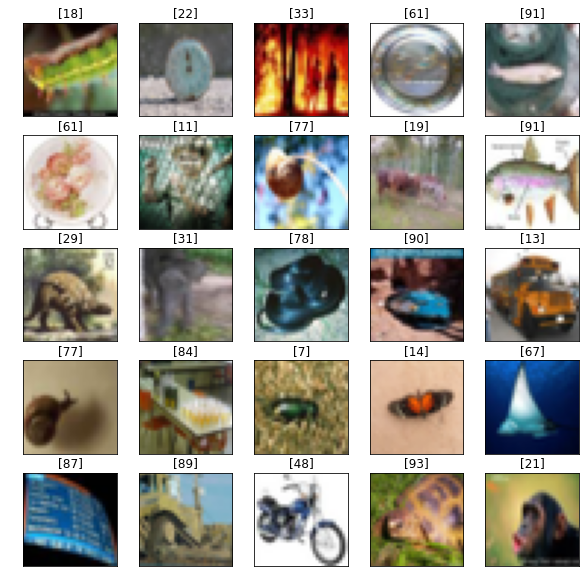

In [2]:
# display a random set of images
plt.figure(figsize=(10,10))
for i in range(25):
    rand_num=np.random.randint(0,50000)
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(x_train[rand_num])
    # Erase the value of a tick
    plt.xticks(color="None")
    plt.yticks(color="None")
    # Erase the tick x-axis and y-axis
    plt.tick_params(length=0)
    # Show correct label
    plt.title(y_train[rand_num])
 
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
! ls

gdrive	sample_data


In [5]:
%cd /content/gdrive/MyDrive/CIFAR100

/content/gdrive/MyDrive/CIFAR100


In [6]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D, GlobalAveragePooling2D
from keras.layers.core import Dense,Activation,Dropout,Flatten
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import pickle

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

In [7]:
# Normalize the images to a range of 0-1
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
 
# One-Hot encode labels of y_train,y_test to convert data into categorical
y_train = np_utils.to_categorical(y_train,100)
y_test = np_utils.to_categorical(y_test,100)

In [8]:
def create_DenseNet_model():
  # create the base pre-trained model
  base_model = DenseNet121(weights='imagenet', include_top=False, pooling='max')

  x = base_model.output
  x = Flatten()(x)
  # add a fully-connected layer
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.25)(x)

  # and a logistic layer
  predictions = Dense(100, activation='softmax')(x)
    
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [9]:
def create_VGG_model():
  # Create VGG Model
  model = Sequential()
  
  model.add(Conv2D(32,(3,3),padding='same',input_shape=(32,32,3)))
  model.add(Activation('relu'))
  model.add(Conv2D(32,(3,3),padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64,(3,3),padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64,(3,3),padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(100,activation='softmax'))
  
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  model.summary()
  return model

In [10]:
def grid_search():  
  model = create_VGG_model()
  data_augmentation = True
  batch_size = [10, 20, 40, 60, 80, 100, 128]
  epochs = [10, 50, 100]
  validations = []
  grid_result_loss = []
  grid_result_acc = []
  grid_params = []

  for size in batch_size:
    for e in epochs:
      if not data_augmentation:
          print('Not using data augmentation.')
          model.fit(x_train, y_train, batch_size=size, epochs=e, validation_data=(x_test, y_test), verbose=1)
          score = model.evaluate(x_test,y_test,verbose=0)
          grid_result_loss.append(score[0])
          grid_result_acc.append(score[1])
          grid_params.append([size, e])
      else:
          print('Using real-time data augmentation.')
          # data preprocessing and data augmentation
          datagen = ImageDataGenerator(
              featurewise_center=False,  # set input mean to 0 over the dataset
              samplewise_center=False,  # set each sample mean to 0
              featurewise_std_normalization=False,  # divide inputs by std of the dataset
              samplewise_std_normalization=False,  # divide each input by its std
              zca_whitening=False,  # apply ZCA whitening
              rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
              width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
              height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
              horizontal_flip=True,  # randomly flip images
              vertical_flip=False)  # randomly flip images

          datagen.fit(x_train)

          # Fit the model on the batches generated by datagen.flow()
          model.fit_generator(datagen.flow(x_train, y_train, batch_size=size), epochs=e, validation_data=(x_test, y_test))
          score = model.evaluate(x_test,y_test,verbose=0)
          grid_result_loss.append(score[0])
          grid_result_acc.append(score[1])
          grid_params.append([size, e])
  #Best model
  best_model = grid_result_acc.index(max(grid_result_acc))
  print("Best: %f using %s" % (grid_result_acc[best_model], grid_result_params[best_model]))
  return grid_params[best_model]

In [11]:
#params = grid_search()

In [12]:
from timeit import default_timer as timer
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

model_architecture = "vgg"

if model_architecture == "vgg":
  model = create_VGG_model()
else:
  model = create_DenseNet_model()

data_augmentation = True
#Best parameters found from grid search
batch_size = 128
epochs = 100

if not data_augmentation:
  print('Not using data augmentation.')
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=1, callbacks=[cb])
else:
  print('Using real-time data augmentation.')
  # data preprocessing and data augmentation
  datagen = ImageDataGenerator(
      featurewise_center=False,  # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
      width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
      height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False)  # randomly flip images

  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow()
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(x_test, y_test), verbose=1, callbacks=[cb])

# Save model and weights as json file
json_string = model.to_json()
open('/content/gdrive/MyDrive/CIFAR100/cifar100_cnn.json',"w").write(json_string)
 
# Save weights as h5 file
model.save_weights('/content/gdrive/MyDrive/CIFAR100/cifar100_cnn.h5')

# Evaluation
score = model.evaluate(x_test,y_test,verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])
print("Test loss : " + str(score[0]) + ", Test accuracy : " + str(score[1]*100) + "% ")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [13]:
len(model.layers)

17

In [14]:
print(sum(cb.logs))

1811.8641283369998


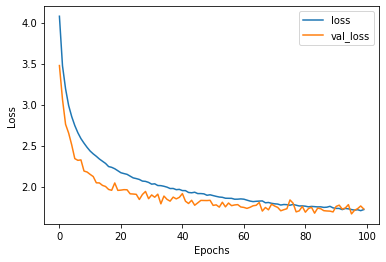

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

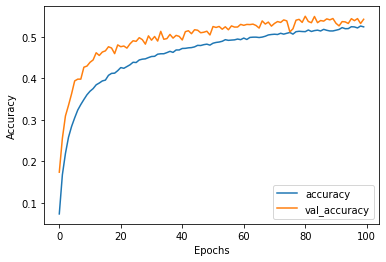

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


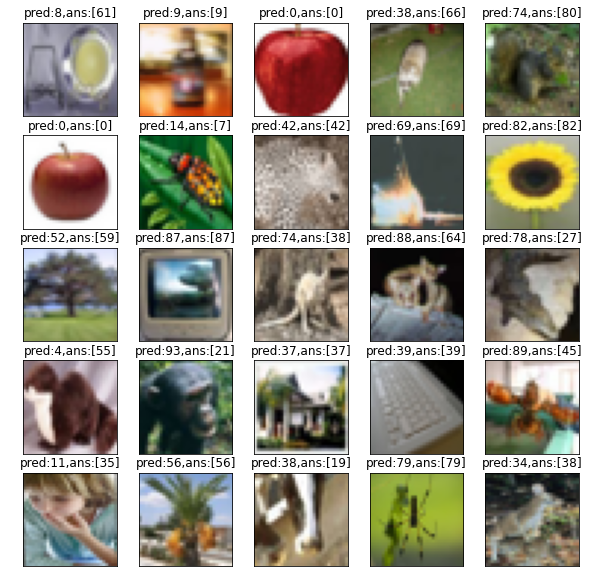

In [17]:
img_pred = model.predict_classes(x_test)
 
plt.figure(figsize=(10,10))
for i in range(25):
    rand_num=np.random.randint(0,10000)
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(x_test_img[rand_num])
    # Erase the value of a tick
    plt.xticks(color="None")
    plt.yticks(color="None")
    # Erase the tick x-axis and y-axis
    plt.tick_params(length=0)
    # Image Prediction pred:ans:
    plt.title('pred:{0},ans:{1}'.format(img_pred[rand_num],y_test_img[rand_num]))
 
plt.show()

Confusion matrix, without normalization
[[64  2  1 ...  0  0  0]
 [ 0 72  0 ...  0  0  1]
 [ 0  3 45 ...  1  4  0]
 ...
 [ 0  0  0 ... 52  0  0]
 [ 0  1  7 ...  0 34  2]
 [ 0  1  0 ...  0  0 55]]


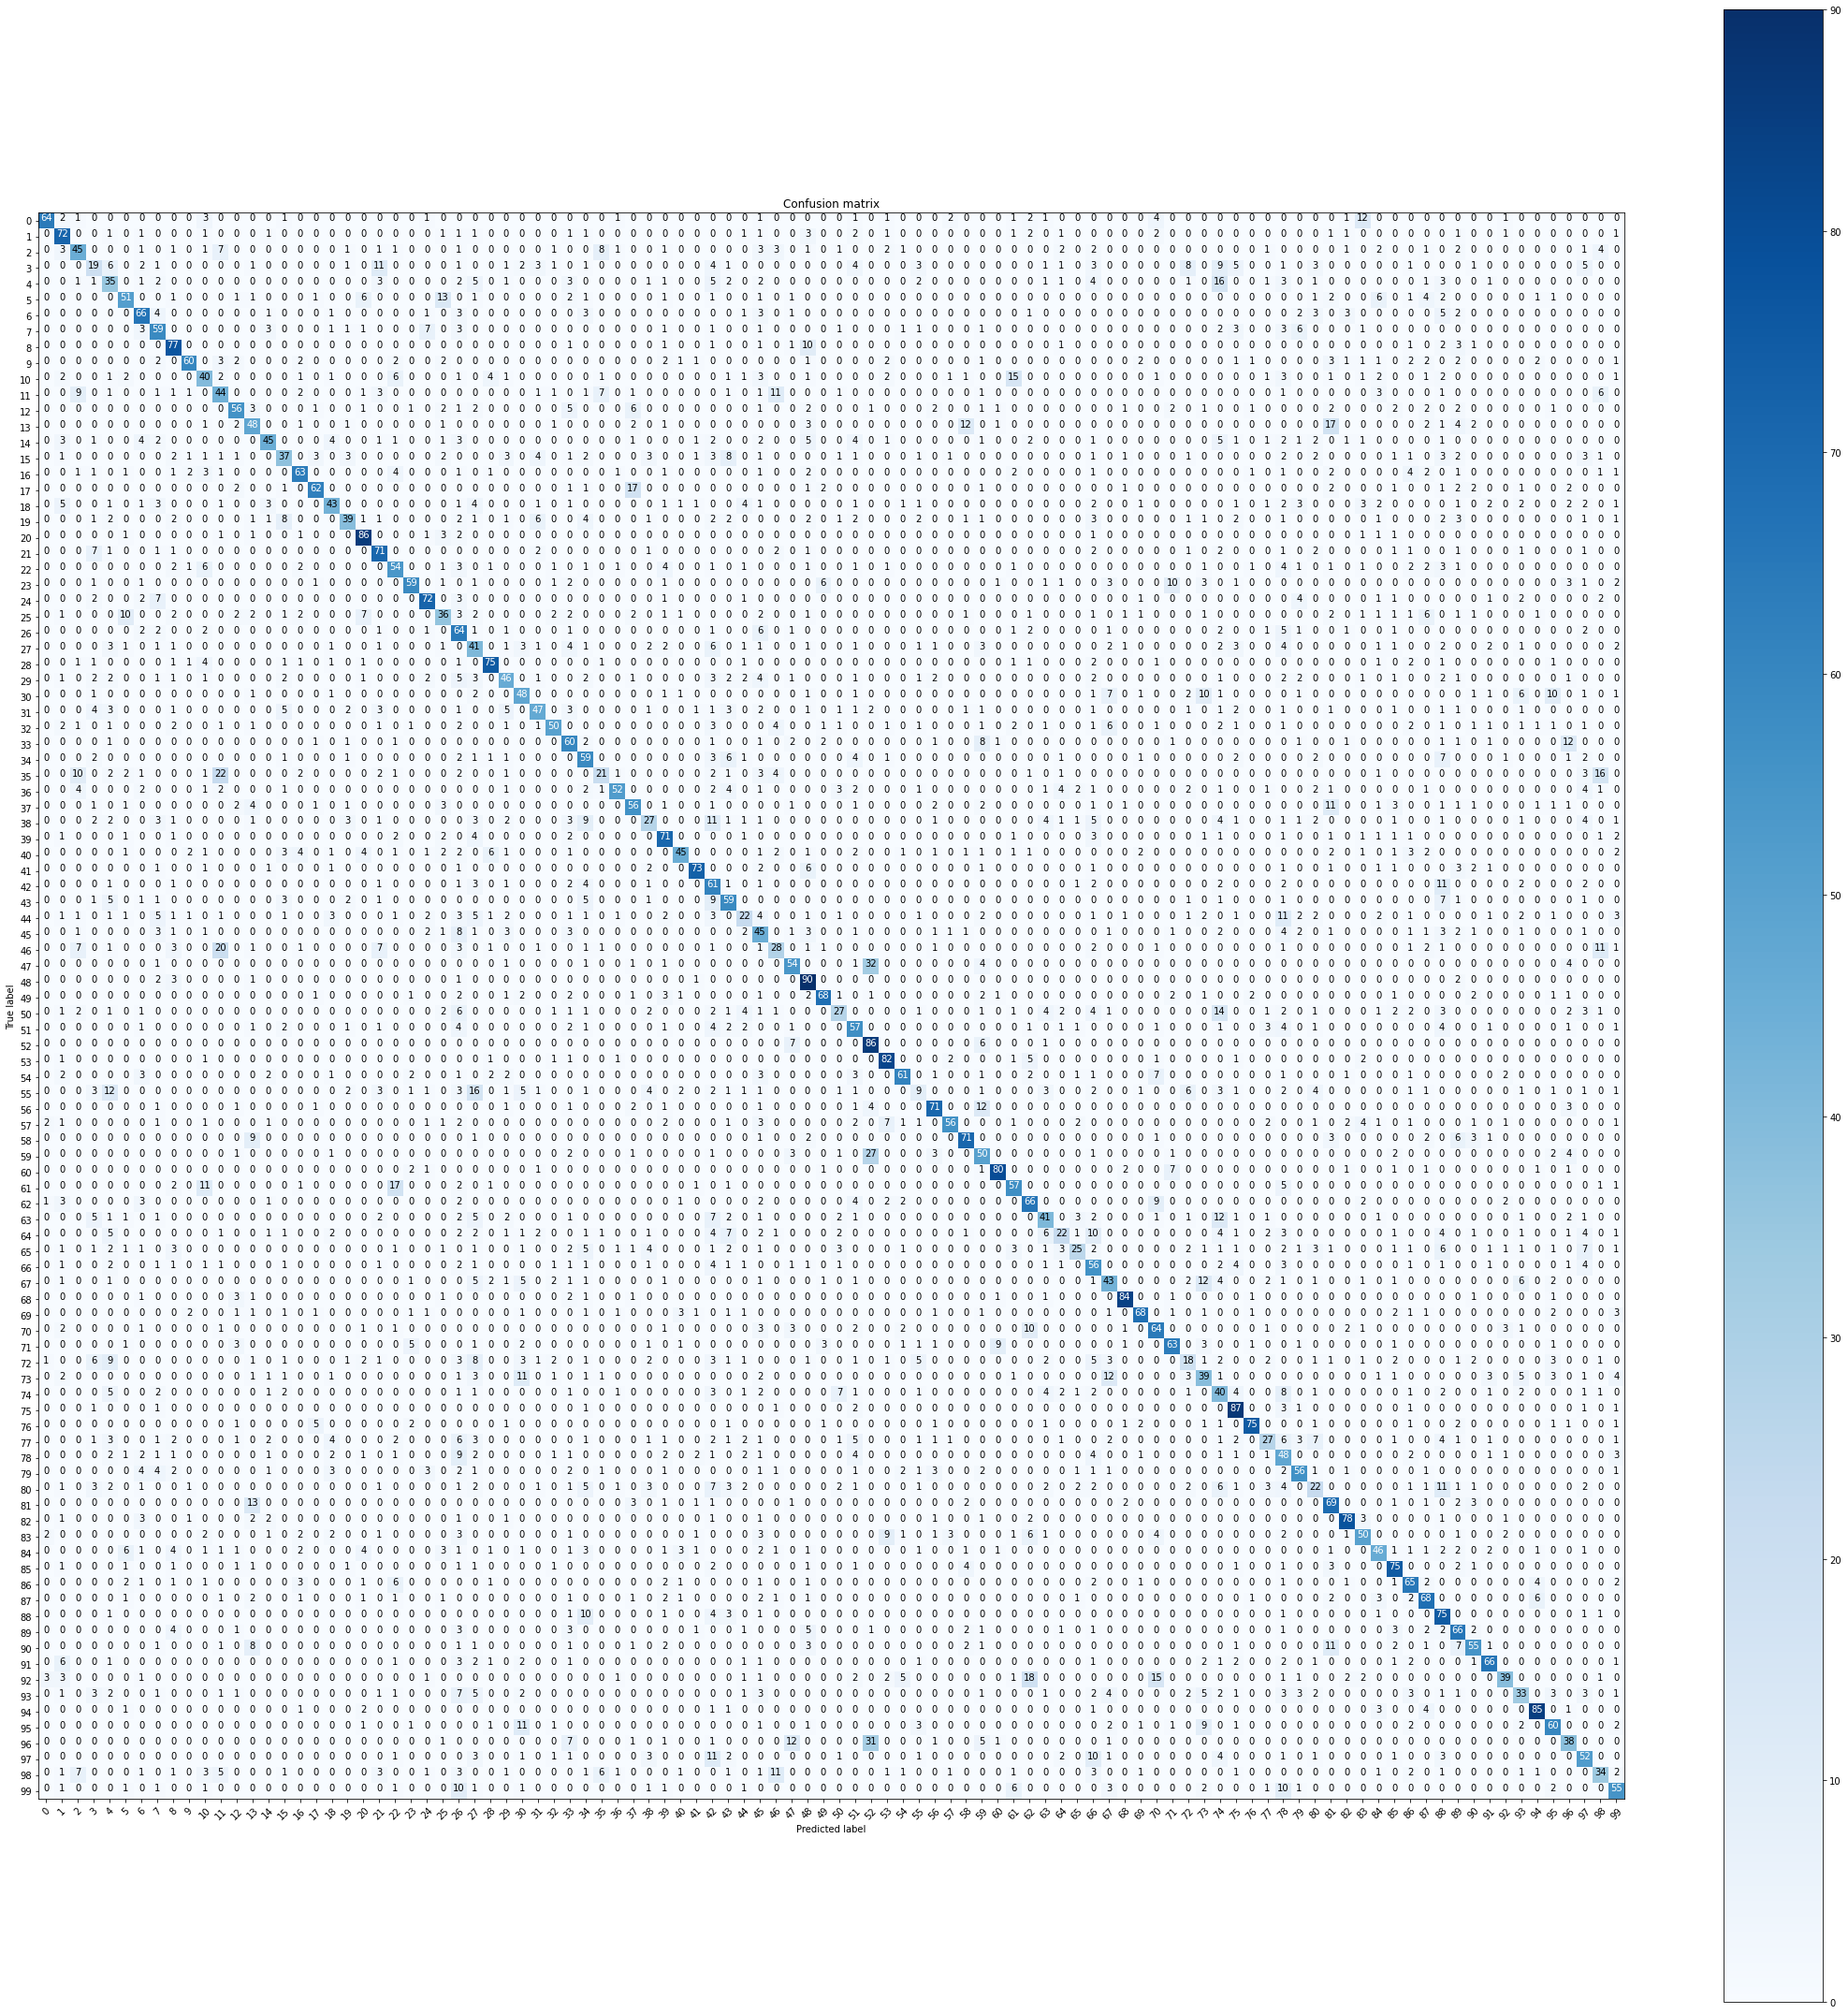

In [18]:
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib.pyplot import subplots

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict_classes(x_test)
cm = confusion_matrix(y_test_img, p_test)
plt.subplots(figsize=(30, 30))
plot_confusion_matrix(cm, range(100), normalize = False)
plt.show()